In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline

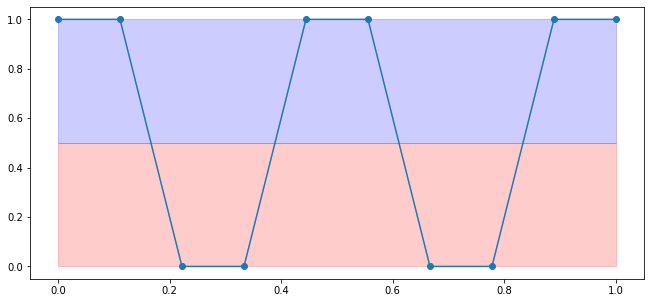

In [18]:
train_x = torch.linspace(0, 1, 10)
train_y = torch.sign(torch.cos(train_x * (4 * math.pi))).add(1).div(2)


fig, ax = plt.subplots(figsize=(11,5))

ax.plot(train_x.detach().numpy(), train_y.detach().numpy(), marker='o')

ax.fill_between(train_x, 0.5, 1.0, alpha=0.2, color='blue')
ax.fill_between(train_x, 0., 0.5, alpha=0.2, color='red')
plt.show()

In [5]:
from gpytorch.models import AbstractVariationalGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy


class GPClassificationModel(AbstractVariationalGP):
    def __init__(self, train_x):
        variational_distribution   = CholeskyVariationalDistribution(train_x.size(0))
        variational_strategy       = VariationalStrategy(self, train_x, variational_distribution)
        super(GPClassificationModel, self).__init__(variational_strategy)
        self.mean_module           = gpytorch.means.ConstantMean()
        self.covar_module          = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred


# Initialize model and likelihood
model = GPClassificationModel(train_x)
likelihood = gpytorch.likelihoods.BernoulliLikelihood()

In [19]:
from gpytorch.mlls.variational_elbo import VariationalELBO

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
# num_data refers to the amount of training data
mll = VariationalELBO(likelihood, model, train_y.numel())

training_iter = 50
for i in range(training_iter):
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 0.908
Iter 2/50 - Loss: 5.447
Iter 3/50 - Loss: 8.831
Iter 4/50 - Loss: 3.976
Iter 5/50 - Loss: 6.262
Iter 6/50 - Loss: 7.334
Iter 7/50 - Loss: 6.449
Iter 8/50 - Loss: 4.526
Iter 9/50 - Loss: 3.419
Iter 10/50 - Loss: 3.036
Iter 11/50 - Loss: 2.820
Iter 12/50 - Loss: 2.658
Iter 13/50 - Loss: 2.446
Iter 14/50 - Loss: 2.139
Iter 15/50 - Loss: 1.710
Iter 16/50 - Loss: 1.537
Iter 17/50 - Loss: 1.514
Iter 18/50 - Loss: 1.507
Iter 19/50 - Loss: 1.474
Iter 20/50 - Loss: 1.430
Iter 21/50 - Loss: 1.404
Iter 22/50 - Loss: 1.396
Iter 23/50 - Loss: 1.394
Iter 24/50 - Loss: 1.389
Iter 25/50 - Loss: 1.378
Iter 26/50 - Loss: 1.359
Iter 27/50 - Loss: 1.334
Iter 28/50 - Loss: 1.304
Iter 29/50 - Loss: 1.270
Iter 30/50 - Loss: 1.235
Iter 31/50 - Loss: 1.199
Iter 32/50 - Loss: 1.165
Iter 33/50 - Loss: 1.134
Iter 34/50 - Loss: 1.108
Iter 35/50 - Loss: 1.088
Iter 36/50 - Loss: 1.074
Iter 37/50 - Loss: 1.063
Iter 38/50 - Loss: 1.051
Iter 39/50 - Loss: 1.036
Iter 40/50 - Loss: 1.016
Iter 41/5

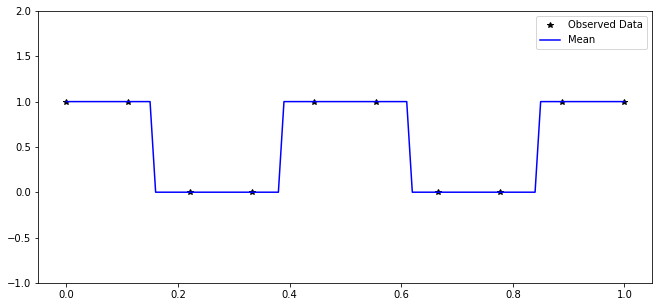

In [21]:

# Go into eval mode
model.eval()
likelihood.eval()

with torch.no_grad():
    # Test x are regularly spaced by 0.01 0,1 inclusive
    test_x = torch.linspace(0, 1, 101)
    # Get classification predictions
    observed_pred = likelihood(model(test_x))

    # Initialize fig and axes for plot
    f, ax = plt.subplots(1, 1, figsize=(11, 5))
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Get the predicted labels (probabilites of belonging to the positive class)
    # Transform these probabilities to be 0/1 labels
    pred_labels = observed_pred.mean.ge(0.5).float()
    ax.plot(test_x.numpy(), pred_labels.numpy(), 'b')
    ax.set_ylim([-1, 2])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])